# Sparkify Data Science Nanodegree Capstone Project

* The goal of this data science project is to predict user churn, i.e., identify what causes users to create a subscription or cancel it respectively.
* Instead of using the pandas library, we instead use the Apache Spark framework, which is build for big data analysis running on clusters.
* The dataset used is only a fraction of the original dataset, which is about 12GB large and stored on AWS S3 (in a first step we use the small dataset; later we'll run this notebook on an AWS EMR Cluster)

# Set up Spark and other Dependencies

In [167]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, split, trim, expr, datediff, from_unixtime

from pyspark.ml.feature import RegexTokenizer, CountVectorizer, \
    IDF, StringIndexer

import datetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

In [168]:
spark = SparkSession \
    .builder \
    .appName("sparkify") \
    .getOrCreate()

In [169]:
spark

In [170]:
path = "mini_sparkify_event_data.json"
user_log = spark.read.json(path)

Run the cell below to increase width of notebook. Will be needed for SQL data operations.

In [171]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
display(HTML("<style>.output_result { max-width:100% !important; }</style>"))

# Data Exploration

To learn more about the users the follwoing questions need to answered:


## Who are the Users?

* What gender do users have?
* Where do they live?
* What are their favorite artists/songs?

## How do they interact with the Platform?

### Platform Usage

* How often do they use the platform?
* Do users who cancel their subscription don't use the platform or do they and might not like it?
* How long is an average session per user?
* What devices do they use to access the platform?

### Subscription Behavior

* How often do users switch their subscription level (paid/free)
* Is there a leading indicator that a user might cancel his paid subscriptions, e.g., high count of thumbs down



In [172]:
user_log.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [173]:
user_log.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')

The timestamp format is not in a readable format. By creating the user defined function `get_datetime` and applying this function onto the ts column we obtain the dateTime column which has a convenient format

In [174]:
# get_datetime = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%Y-%m-%d %H:%M:%S"))

# user_log = user_log.withColumn("ts_iso", get_datetime(user_log.ts)) \
#             .withColumn("registration_iso", get_datetime(user_log.registration))

# use pysparks built-in function to handel unix timestamps (divide by 1000 to convert from milliseconds)
user_log = user_log.withColumn("ts_iso", from_unixtime(user_log.ts/1000)) \
                .withColumn("registration_iso", from_unixtime(user_log.registration/1000))

The location column contains both city and state, we want to isolate both of them into seperate columns

In [175]:
user_log = user_log.withColumn('city', trim(split(user_log['location'], ',').getItem(0))) \
            .withColumn('state', trim(split(user_log['location'], ',').getItem(1)))

The userAgent columns contains information about which end-device was used to access the platform. Therfore it is usefull to learn something about the platform's users

In [176]:
user_log = user_log.withColumn('userDevice', expr("CASE WHEN lower(userAgent) LIKE '%windows%' THEN 'windows'"+
                                       "WHEN lower(userAgent) LIKE '%macintosh%' THEN 'mac'" +
                                        "WHEN lower(userAgent) LIKE '%linux%' THEN 'linux'" +
                                        "WHEN lower(userAgent) LIKE '%iphone%' THEN 'mobile'" +
                                        "WHEN lower(userAgent) LIKE '%ipad%' THEN 'mobile'" +
                                        "ELSE 'other'" +
                                        "END"))

In [177]:
user_log.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', ts_iso='2018-10-01 02:01:57', registration_iso='2018-09-29 00:22:42', city='Bakersfield', state='CA', userDevice='windows')

Since we are interested in predicting user behavior, actions recorded in the dataset need to be attributed to a userid. For records without a userId we are not able to draw conclusions on the behaviour.

In [178]:
print('{} records in the dataset have no userId. They will be dropped'.format(user_log.filter(user_log.userId == '').count()))
user_log = user_log.where(user_log.userId != '')
print('{} records in the dataset have no userId.'.format(user_log.filter(user_log.userId == '').count()))


8346 records in the dataset have no userId. They will be dropped
0 records in the dataset have no userId.


## Leveraging PySpark's SQL Function for Data Exploration

In [179]:
# create temporary view against which SQL queries can be run
user_log.createOrReplaceTempView("user_log_table")

### Create a table that contains user subscription behavior

Idea of the query below:

1. `errors_tab`
    * Assign each entry row number to maintain order of events (have consecutive entries with exact same timestamp)
    * Some actions are not realized because an error follows in the logs. Thus if entry $t+1$ has page "Error", set a flag for entry $t$

2. `records_tab`
    * When level at $t$ is different from $t-1$ a new regime starts. Set a flag
    * When level at $t$ is "paid" and level at $t+1$ is "free", the regime at $t$ is cancelled. Set a flag
    * Choose only actions that don't result in errors

3. `regime_tab`
    * Sum up the flag set in the `records_tab`. Whenever the level changes, the `regime_count` increases by 1

4. `regime_dates`
    * The `regime_start` in the first regime is per assumption the registration date, as we don't have other data available. In later regimes $n>1$ we'll take the timestamp of the first record of regime $n$
    * In the last regime, $N$, the `regime_end` is the max. timestamp in the dataset. Else it's the timestamp of the latest record in the particular regime $n<N$

5. Final Result
    * Collect the pre-processed data
    * Obtain aggregate values per regime

In [270]:
user_regime = spark.sql("""
                        with errors_tab AS(
                        SELECT
                            userId, page, level, date(ts_iso), date(registration_iso),
                            row_number() OVER(PARTITION BY userId ORDER BY userId, ts_iso) record_number,
                            CASE WHEN LEAD(page) OVER(PARTITION BY userId ORDER BY userId, ts_iso) = 'Error' THEN 1 ELSE 0 END leads_to_error
                        FROM user_log_table
                        ),


                        records_tab as(
                        SELECT
                            userId, page, level, ts_iso, registration_iso, record_number,
                            CASE WHEN LAG(level) OVER(PARTITION BY userId ORDER BY record_number) != level THEN 1 ELSE 0 END regime_change,
                            CASE WHEN LEAD(level) OVER(PARTITION BY userId ORDER BY record_number) = 'free' and level = 'paid' THEN 1 ELSE 0 END cancel_regime
                        FROM errors_tab
                        WHERE leads_to_error = 0
                        ),


                        regime_tab AS(
                        SELECT userId, page, level, ts_iso, registration_iso, record_number, cancel_regime,
                            SUM(regime_change) OVER(PARTITION BY userId ORDER BY record_number)+1 regime_count
                        FROM records_tab),


                        regime_dates AS(            
                        SELECT userId, page, level, record_number, cancel_regime, regime_count,
                            CASE
                                WHEN regime_count = 1 THEN registration_iso
                                WHEN regime_count > 1 THEN first_value(ts_iso) OVER(PARTITION BY userId, regime_count)
                            END regime_start,                
                            CASE
                                WHEN regime_count = last_value(regime_count) OVER(PARTITION BY userId)
                                    THEN (select date(max(ts_iso)) FROM user_log_table)
                                    ELSE date(last_value(ts_iso) OVER(PARTITION BY userId, regime_count))
                            END regime_end
                        FROM regime_tab)

                        SELECT
                            DISTINCT userId,
                            level,
                            regime_count,
                            regime_start,
                            regime_end,
                            sum(cancel_regime) OVER(PARTITION BY userId, regime_count) = 1 regime_cancelled,
                            count_if(page = 'NextSong') OVER(PARTITION BY userId, regime_count) next_song,
                            count_if(page = 'Thumbs Up') OVER(PARTITION BY userId, regime_count) thumbs_up,
                            count_if(page = 'Thumbs Down') OVER(PARTITION BY userId, regime_count) thumbs_down,
                            count_if(page = 'Add Friend') OVER(PARTITION BY userId, regime_count) add_friend,
                            count_if(page = 'Add to Playlist') OVER(PARTITION BY userId, regime_count) add_to_playlist,
                            count_if(page = 'Save Settings') OVER(PARTITION BY userId, regime_count) save_settings,
                            count_if(page = 'Error') OVER(PARTITION BY userId, regime_count) error,
                            count_if(page = 'HELP') OVER(PARTITION BY userId, regime_count) help

                        FROM regime_dates
                        ORDER BY userId, regime_count

                        """)
# store results in temporary view: user_regime_table
user_regime.createOrReplaceTempView("user_regime_table")
user_regime.show()

+------+-----+------------+------------+----------+----------------+---------+---------+-----------+----------+---------------+-------------+-----+----+
|userId|level|regime_count|regime_start|regime_end|regime_cancelled|next_song|thumbs_up|thumbs_down|add_friend|add_to_playlist|save_settings|error|help|
+------+-----+------------+------------+----------+----------------+---------+---------+-----------+----------+---------------+-------------+-----+----+
|    10| paid|           1|  2018-09-28|2018-12-03|           false|      673|       37|          4|        12|              9|            1|    0|   0|
|   100| paid|           1|  2018-09-26|2018-11-04|            true|     1604|       84|         14|        32|             43|            5|    1|   0|
|   100| free|           2|  2018-11-04|2018-11-14|           false|      231|       11|          1|         6|              4|            0|    1|   0|
|   100| paid|           3|  2018-11-14|2018-12-03|           false|      844|    

### Todo:
Update query below to match new `user_regime_table`

In [48]:
spark.sql("""
            SELECT
                userId,
                count_if(level='paid') paid_regimes,
                count_if(level='free') free_regimes,
                sum(regime_cancelled) cancelled_regimes,
                round(sum(regime_days) filter(where level='paid')/count_if(level='paid'),2) avg_paid_regime_days,
                round(sum(regime_days) filter(where level='free')/count_if(level='free'),2) avg_free_regime_days,
                round(sum(regime_thumbs_up) filter(where level='paid')/count_if(level='paid'),2) avg_paid_regime_thumbs_up,
                round(sum(regime_thumbs_up) filter(where level='free')/count_if(level='free'),2) avg_free_regime_thumbs_up,
                round(sum(regime_thumbs_down) filter(where level='paid')/count_if(level='paid'),2) avg_paid_regime_thumbs_down,
                round(sum(regime_thumbs_down) filter(where level='free')/count_if(level='free'),2) avg_free_regime_thumbs_down,
                
                round(sum(regime_thumbs_up) filter(where level='paid' and regime_cancelled = 1)/count_if(level='paid'),2) avg_cancelled_regime_thumbs_up,
                round(sum(regime_thumbs_down) filter(where level='paid' and regime_cancelled = 1)/count_if(level='paid'),2) avg_cancelled_regime_thumbs_down
                
            FROM user_regime_table
            GROUP BY
                userId
            
            
            """).show(300)

+------+------------+------------+-----------------+--------------------+--------------------+-------------------------+-------------------------+---------------------------+---------------------------+------------------------------+--------------------------------+
|userId|paid_regimes|free_regimes|cancelled_regimes|avg_paid_regime_days|avg_free_regime_days|avg_paid_regime_thumbs_up|avg_free_regime_thumbs_up|avg_paid_regime_thumbs_down|avg_free_regime_thumbs_down|avg_cancelled_regime_thumbs_up|avg_cancelled_regime_thumbs_down|
+------+------------+------------+-----------------+--------------------+--------------------+-------------------------+-------------------------+---------------------------+---------------------------+------------------------------+--------------------------------+
|   100|           2|           1|                1|                28.5|                 9.0|                     68.5|                     11.0|                       13.0|                        1

In [17]:
user_log.select("auth").groupby("auth").count().show()

+---------+------+
|     auth| count|
+---------+------+
|Cancelled|    52|
|Logged In|278102|
+---------+------+



In [18]:
user_log.select("gender").groupby("gender").count().show()

+------+------+
|gender| count|
+------+------+
|     F|154578|
|     M|123576|
+------+------+



In [19]:
user_log.select("level").groupby("level").count().orderBy("count", ascending=False).show()


+-----+------+
|level| count|
+-----+------+
| paid|222433|
| free| 55721|
+-----+------+



In [20]:
user_log.select("page").groupby("page").count().orderBy("count", ascending=False).show()

+--------------------+------+
|                page| count|
+--------------------+------+
|            NextSong|228108|
|           Thumbs Up| 12551|
|                Home| 10082|
|     Add to Playlist|  6526|
|          Add Friend|  4277|
|         Roll Advert|  3933|
|              Logout|  3226|
|         Thumbs Down|  2546|
|           Downgrade|  2055|
|            Settings|  1514|
|                Help|  1454|
|             Upgrade|   499|
|               About|   495|
|       Save Settings|   310|
|               Error|   252|
|      Submit Upgrade|   159|
|    Submit Downgrade|    63|
|              Cancel|    52|
|Cancellation Conf...|    52|
+--------------------+------+



In [21]:
user_log.select("userDevice").groupby("userDevice").count().orderBy("count", ascending=False).show()

+----------+------+
|userDevice| count|
+----------+------+
|   windows|143871|
|       mac|102749|
|    mobile| 22573|
|     linux|  8961|
+----------+------+



In [22]:
spark.sql('''
        SELECT artist, count(*) as count
        FROM user_log_table
        WHERE artist is not null
        GROUP BY artist
        ORDER BY count(*) DESC
        ''').show()

+--------------------+-----+
|              artist|count|
+--------------------+-----+
|       Kings Of Leon| 1841|
|            Coldplay| 1813|
|Florence + The Ma...| 1236|
|       Dwight Yoakam| 1135|
|            BjÃÂ¶rk| 1133|
|      The Black Keys| 1125|
|                Muse| 1090|
|       Justin Bieber| 1044|
|        Jack Johnson| 1007|
|              Eminem|  953|
|           Radiohead|  884|
|     Alliance Ethnik|  876|
|               Train|  854|
|        Taylor Swift|  840|
|         OneRepublic|  828|
|         The Killers|  822|
|         Linkin Park|  787|
|         Evanescence|  781|
|            Harmonia|  729|
|           Daft Punk|  713|
+--------------------+-----+
only showing top 20 rows



In [23]:
spark.sql('''
        SELECT song, count(*) as count
        FROM user_log_table
        WHERE song is not null
        GROUP BY song
        ORDER BY count(*) DESC
        ''').show()

+--------------------+-----+
|                song|count|
+--------------------+-----+
|      You're The One| 1153|
|                Undo| 1026|
|             Revelry|  854|
|       Sehr kosmisch|  728|
|Horn Concerto No....|  641|
|Dog Days Are Over...|  574|
|             Secrets|  466|
|        Use Somebody|  459|
|              Canada|  435|
|             Invalid|  424|
|    Ain't Misbehavin|  409|
|       ReprÃÂ©sente|  393|
|SinceritÃÂ© Et J...|  384|
|Catch You Baby (S...|  373|
|              Yellow|  343|
|    Somebody To Love|  343|
|    Hey_ Soul Sister|  334|
|            The Gift|  327|
|           Fireflies|  312|
|          Love Story|  309|
+--------------------+-----+
only showing top 20 rows



In [24]:
spark.sql('''
        SELECT artist, song, count(*) as count
        FROM user_log_table
        WHERE
            song is not null
            AND artist is not null
        GROUP BY artist, song
        ORDER BY artist, count(*) DESC
        ''').show()

+--------------------+--------------------+-----+
|              artist|                song|count|
+--------------------+--------------------+-----+
|                 !!!|    Must Be The Moon|    4|
|                 !!!|              Yadnus|    3|
|                 !!!|          A New Name|    2|
|                 !!!|          Myth Takes|    1|
|        & And Oceans|  Odious And Devious|    1|
|'N Sync/Phil Collins|Trashin' The Camp...|    4|
|        'Til Tuesday|        Voices Carry|    2|
| 't Hof Van Commerce|              Jaloes|    1|
|'t Hof Van Commer...|            Leegaert|    1|
|       (Love) Tattoo|Drop Some Drums (...|    1|
|          (hed) p.e.|            Renegade|    2|
|          (hed) p.e.|        Here And Now|    1|
|          (hed) p.e.|      Ordo (ab Chao)|    1|
|*NSYNC featuring ...|          Girlfriend|    1|
|  + / - {Plus/Minus}|The Queen of Nothing|   16|
|  + / - {Plus/Minus}|One Day You'll Be...|    2|
|  + / - {Plus/Minus}|The Important Thi...|    2|


In [25]:
df_membership_days = spark.sql('''
                                SELECT userId, max(membership_days)
                                FROM user_log_table
                                GROUP BY userId
                                ORDER BY max(membership_days) DESC
                                ''').toPandas()

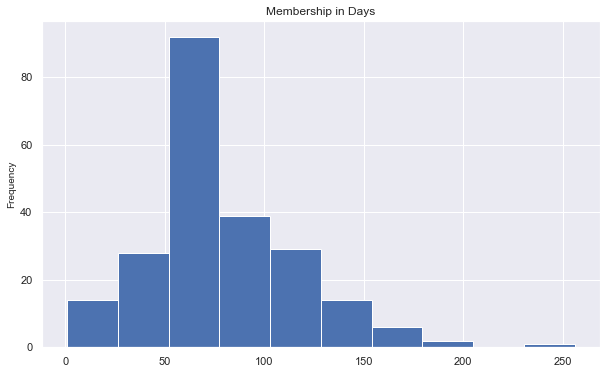

In [26]:
df_membership_days.plot(kind='hist', title='Membership in Days', legend=False, figsize=(10,6));

In [27]:
spark.sql('''
            SELECT userId, max(membership_days)
            FROM user_log_table
            WHERE page = 'Cancellation Confirmation'
            GROUP BY userId
            ORDER BY max(membership_days) DESC
            ''').show()

+------+--------------------+
|userId|max(membership_days)|
+------+--------------------+
|300001|                 188|
|    70|                 145|
|   121|                 132|
|100007|                 115|
|    54|                 110|
|200011|                 110|
|100025|                  89|
|200015|                  88|
|100005|                  85|
|100014|                  85|
|     3|                  81|
|100017|                  78|
|200020|                  76|
|    12|                  73|
|   125|                  72|
|200021|                  71|
|100015|                  68|
|100021|                  65|
|   143|                  62|
|200017|                  61|
+------+--------------------+
only showing top 20 rows



In [39]:
spark.sql('''
            with pretab as(
            SELECT userId, max(membership_days)
            FROM user_log_table
            WHERE page = 'Cancellation Confirmation'
            GROUP BY userId
            ORDER BY max(membership_days) DESC
            )
            SELECT pretab.userId, count(*) records, max(membership_days)
            FROM
                user_log_table
                INNER JOIN pretab on pretab.userId = user_log_table.userId
            GROUP BY pretab.userId
            ORDER BY max(membership_days) desc
            ''').show()

+------+-------+--------------------+
|userId|records|max(membership_days)|
+------+-------+--------------------+
|300001|   2168|                 188|
|    70|   1775|                 145|
|   121|    916|                 132|
|100007|    520|                 115|
|    54|   3437|                 110|
|200011|    848|                 110|
|100025|    623|                  89|
|200015|    349|                  88|
|100005|    216|                  85|
|100014|    310|                  85|
|     3|    254|                  81|
|100017|     75|                  78|
|200020|   1498|                  76|
|    12|   1064|                  73|
|   125|     11|                  72|
|200021|   1502|                  71|
|100015|   1050|                  68|
|100021|    319|                  65|
|   143|    149|                  62|
|200017|    620|                  61|
+------+-------+--------------------+
only showing top 20 rows



In [57]:
df_cancelled_userId = user_log.select('userId').filter(user_log.page == 'Cancellation Confirmation').drop_duplicates()

In [58]:
df_cancelled_userId.createOrReplaceTempView("cancelled_users_table")

In [60]:
spark.sql('''
            with is_home as(
            SELECT
                userID, page, ts,
                CASE WHEN page = 'Home' THEN 1 ELSE 0 END AS is_home                
            FROM user_log_table
            WHERE
                (page = 'NextSong') or (page = 'Home')
            ),
            cum_sum as (
            SELECT *, sum(is_home) OVER(PARTITION BY userID ORDER BY ts DESC ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) as period
            FROM is_home
            )
            SELECT AVG(count_results)
            FROM (
                SELECT COUNT(*) AS count_results FROM cum_sum
                GROUP BY userID, period, page HAVING page = 'NextSong'
            ) as counts
                
            ''').show()

+------------------+
|avg(count_results)|
+------------------+
|23.586805914590013|
+------------------+



In [105]:
spark.sql('''
            with is_home as(
            SELECT
                userId, auth, page, ts,
                CASE WHEN page = 'Home' THEN 1 ELSE 0 END AS is_home                
            FROM user_log_table
            WHERE
                (page = 'NextSong') or (page = 'Home')
            ),
            cum_sum as (
            SELECT *, sum(is_home) OVER(PARTITION BY userID ORDER BY ts DESC ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) as period
            FROM is_home
            )
            SELECT "cancelled_users" as user_state, AVG(count_results) as 
            FROM (
                SELECT COUNT(*) AS count_results FROM cum_sum WHERE userId in (select userId from cancelled_users_table)
                GROUP BY userID, period, page HAVING page = 'NextSong'
            ) as counts
            
            UNION
            
            SELECT "active_users" as user_state, AVG(count_results)
            FROM (
                SELECT COUNT(*) AS count_results FROM cum_sum WHERE userId not in (select userId from cancelled_users_table)
                GROUP BY userID, period, page HAVING page = 'NextSong'
            ) as counts
            
            
            ''').show()

+---------------+------------------+
|          users|avg(count_results)|
+---------------+------------------+
|cancelled_users| 22.67538940809969|
|   active_users|23.768162658070914|
+---------------+------------------+



In [144]:
spark.sql('''
            with is_home as(
            SELECT
                userId, auth, page, ts,
                CASE WHEN page = 'Home' THEN 1 ELSE 0 END AS is_home                
            FROM user_log_table
            WHERE
                (page = 'NextSong') or (page = 'Home')
            ),
            cum_sum as (
            SELECT *, sum(is_home) OVER(PARTITION BY userID ORDER BY ts DESC ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) as period
            FROM is_home
            )
            
            select userId,  from cum_sum
            
                
            ''').show()

+------+---------+--------+-------------+-------+------+
|userId|     auth|    page|           ts|is_home|period|
+------+---------+--------+-------------+-------+------+
|    10|Logged In|NextSong|1542631753000|      0|     0|
|    10|Logged In|    Home|1542631690000|      1|     1|
|    10|Logged In|NextSong|1542631517000|      0|     1|
|    10|Logged In|NextSong|1542631090000|      0|     1|
|    10|Logged In|NextSong|1542630866000|      0|     1|
|    10|Logged In|NextSong|1542630637000|      0|     1|
|    10|Logged In|NextSong|1542630394000|      0|     1|
|    10|Logged In|NextSong|1542630247000|      0|     1|
|    10|Logged In|NextSong|1542630029000|      0|     1|
|    10|Logged In|NextSong|1542629861000|      0|     1|
|    10|Logged In|NextSong|1542629636000|      0|     1|
|    10|Logged In|NextSong|1542629464000|      0|     1|
|    10|Logged In|NextSong|1542629238000|      0|     1|
|    10|Logged In|NextSong|1542629028000|      0|     1|
|    10|Logged In|NextSong|1542

In [131]:
spark.sql('''
            SELECT userId, auth, ts, ts_iso, page, sessionId
            FROM user_log_table
            WHERE (page = 'Home' or page = 'NextSong')
                and userId=10
            ORDER BY userId, ts asc
            ''').show(1000)

+------+---------+-------------+-------------------+--------+---------+
|userId|     auth|           ts|             ts_iso|    page|sessionId|
+------+---------+-------------+-------------------+--------+---------+
|    10|Logged In|1538965220000|2018-10-08 04:20:20|NextSong|        9|
|    10|Logged In|1538965485000|2018-10-08 04:24:45|NextSong|        9|
|    10|Logged In|1538965685000|2018-10-08 04:28:05|NextSong|        9|
|    10|Logged In|1538965893000|2018-10-08 04:31:33|NextSong|        9|
|    10|Logged In|1538966419000|2018-10-08 04:40:19|NextSong|        9|
|    10|Logged In|1538966691000|2018-10-08 04:44:51|NextSong|        9|
|    10|Logged In|1538966898000|2018-10-08 04:48:18|NextSong|        9|
|    10|Logged In|1538967004000|2018-10-08 04:50:04|NextSong|        9|
|    10|Logged In|1538967243000|2018-10-08 04:54:03|NextSong|        9|
|    10|Logged In|1538967507000|2018-10-08 04:58:27|NextSong|        9|
|    10|Logged In|1538967870000|2018-10-08 05:04:30|NextSong|   

### Todo

To understand how users interact with the platform, need to know:

* Songs per session
* Session count
* Session frequency
    * Sessions over membership days
    * Avg time between sessions

Need to differentiate between cancelled and active users (makes sense to add `cancelled` indicator to user_log dataframe)

# Feature Engineering

* User inactivity: if a user only listens to a handful of songs per month or no songs at all, a cancellation might be likely
    * The ratio of songs listend over time being a paying client might be a good predictor
* Number of thumbs up/down they gave before cancelling

# Modeling

In version 3.3.2 spark supports the following classification algorithms:

* Logistic regression
    * Binomial logistic regression
    * Multinomial logistic regression
* Decision tree classifier
* Random forest classifier
* Gradient-boosted tree classifier
* Multilayer perceptron classifier
* Linear Support Vector Machine
* One-vs-Rest classifier (a.k.a. One-vs-All)
* Naive Bayes
* Factorization machines classifier

We'll choose the four most popular: Logistic regression, Random forest classifier, Gradient-boosted tree classifier and Linear Support Vector Machine